## 大きな修正箇所↓
最初に提出したプログラムの交差検証が間違っているとしたら、恐らく下記のプログラムが正しいということになります。<br/>
**最終的なAUCも0.65近くまで落ちてしまいます**。また、**重要な説明変数は「59」「21」「117」ではなく、「59」「21」**となります。<br/>
そのため資料を訂正するとしたら、**「4.説明変数の絞り込み」(4.1～4.5) 「5.重要な説明変数の選定」(5.2～5.5)**の部分の資料となります。<br/>
但しRulefitやEDAの方は特に影響はないため、資料に訂正はありません。

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier #ランダムフォレスト
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import confusion_matrix #混同行列
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, KFold, cross_val_score
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor,GradientBoostingRegressor, 
                              RandomForestRegressor,  GradientBoostingRegressor)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb #LightGBM
import warnings
warnings.filterwarnings("ignore")
# You can go offline on demand by using
# cf.go_offline() 
# initiate notebook for offline plot
# init_notebook_mode(connected=False)         
# set some display options:
plt.rcParams['figure.dpi'] = 100
# colors = px.colors.qualitative.Prism
# pio.templates.default = "plotly_white"

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)
%matplotlib inline
#グラフのフォント変換
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('uci-secom.csv')

#時系列順に並び変える
df = df.sort_values('Time')
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-01-08 02:02:00,3016.64,2492.80,2246.4889,1006.9548,1.0997,100.0,103.3222,0.1184,1.5068,...,20.8909,0.4984,0.0146,0.0040,2.9336,0.0296,0.0062,0.0018,20.8909,-1
1,2008-01-08 05:52:00,2980.84,2628.76,2187.5222,1268.6598,1.4503,100.0,102.4622,0.1233,1.4672,...,187.3554,0.5010,0.0289,0.0061,5.7753,0.0297,0.0556,0.0150,187.3554,1
2,2008-01-08 10:20:00,2847.81,2461.38,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.4970,...,33.4515,0.4970,0.0093,0.0028,1.8722,0.0343,0.0115,0.0032,33.4515,-1
3,2008-01-08 10:26:00,NaN,2544.52,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.4727,...,134.2014,0.5053,0.0121,0.0029,2.3957,0.0139,0.0187,0.0064,134.2014,-1
4,2008-01-08 11:28:00,2975.64,2508.28,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.5079,...,NaN,0.5001,0.0119,0.0033,2.3709,0.0139,0.0187,0.0064,134.2014,-1


In [3]:
#目的変数の1,0化
for i,value in enumerate(df['Pass/Fail']):
    if value == -1:
        df['Pass/Fail'][i] = 0
    else:
        df['Pass/Fail'][i] = 1

In [4]:
#欠損値の確認
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

df_na = null_values(df)
df_na_index = df_na.index

In [5]:
#45%以上の欠損値の除外
df_na_columns = df_na.query('Percentage > 45').index #32個あり
df = df.drop(df_na_columns,axis=1)
print(df.shape)
df.head()

(1567, 560)


,Time,0,1,2,3,4,5,6,7,8,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-01-08 02:02:00,3016.64,2492.80,2246.4889,1006.9548,1.0997,100.0,103.3222,0.1184,1.5068,...,21.2281,0.4984,0.0146,0.0040,2.9336,0.0296,0.0062,0.0018,20.8909,0
1,2008-01-08 05:52:00,2980.84,2628.76,2187.5222,1268.6598,1.4503,100.0,102.4622,0.1233,1.4672,...,16.3616,0.5010,0.0289,0.0061,5.7753,0.0297,0.0556,0.0150,187.3554,1
2,2008-01-08 10:20:00,2847.81,2461.38,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.4970,...,18.4846,0.4970,0.0093,0.0028,1.8722,0.0343,0.0115,0.0032,33.4515,0
3,2008-01-08 10:26:00,NaN,2544.52,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.4727,...,11.3646,0.5053,0.0121,0.0029,2.3957,0.0139,0.0187,0.0064,134.2014,0
4,2008-01-08 11:28:00,2975.64,2508.28,2202.7111,1010.4454,1.0032,100.0,104.3067,0.1225,1.5079,...,21.8407,0.5001,0.0119,0.0033,2.3709,0.0139,0.0187,0.0064,134.2014,0


In [6]:
#とりあえず欠損値の補完をしてみる
df_median = df.fillna(df.median())#中央値での補完
df_0 = df.fillna(0)

In [7]:
# #データの標準化
# df_median = df_median.drop(['Time','Pass/Fail'],axis=1)
# scaler = StandardScaler()
# scaler.fit(df_median)
# scaler.transform(df_median)
# df_median = pd.DataFrame(scaler.transform(df_median), columns=df_median.columns)
# df_median = pd.concat([df_median,df[['Pass/Fail','Time']]],axis=1)

In [8]:
#訓練データとテストデータの分割 train=1~8月 test=9~12月
x_train = df_median.query('Time < "2008-08-31"').drop(['Time','Pass/Fail'],axis=1)
x_test = df_median.query('Time > "2008-08-31"').drop(['Time','Pass/Fail'],axis=1)
y_train = df_median.query('Time < "2008-08-31"')['Pass/Fail']
y_test = df_median.query('Time > "2008-08-31"')['Pass/Fail']

In [9]:
x_train.shape, y_train.shape , x_test.shape, y_test.shape

((944, 558), (944,), (623, 558), (623,))

### ロジスティクス回帰のLassoを実行するには,scikit-learnのLogisticRegressionのパラメータを指定することでLasso回帰のように正則化項を設けられることが分かった．

Lasso alpha=0.0001
Cross-Validation scores: [0.92424242 0.92424242 0.92424242 0.92424242 0.92424242]
Average score: 0.924
使用された特徴量の数: 2

Lasso回帰
auc_検証用:0.539


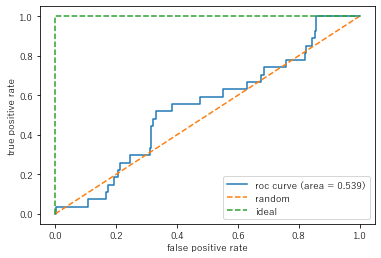

Lasso回帰
auc_テストデータ:0.472


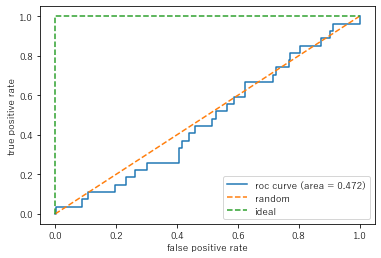

Lasso alpha=0.001
Cross-Validation scores: [0.91666667 0.92424242 0.91666667 0.89393939 0.92424242]
Average score: 0.915
使用された特徴量の数: 21

Lasso回帰
auc_検証用:0.542


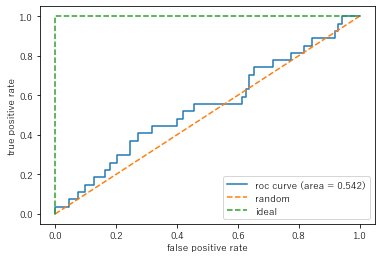

Lasso回帰
auc_テストデータ:0.508


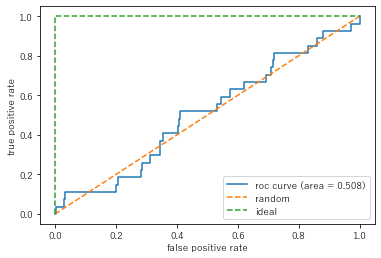

Lasso alpha=0.01
Cross-Validation scores: [0.90151515 0.88636364 0.91666667 0.91666667 0.91666667]
Average score: 0.908
使用された特徴量の数: 61

Lasso回帰
auc_検証用:0.552


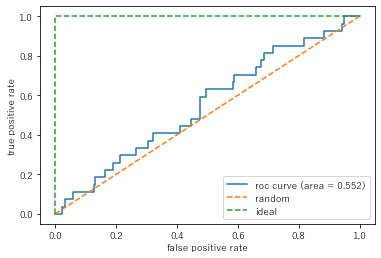

Lasso回帰
auc_テストデータ:0.545


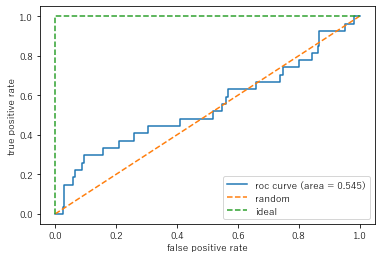

Lasso alpha=0.1
Cross-Validation scores: [0.86363636 0.87878788 0.84848485 0.89393939 0.88636364]
Average score: 0.874
使用された特徴量の数: 110

Lasso回帰
auc_検証用:0.553


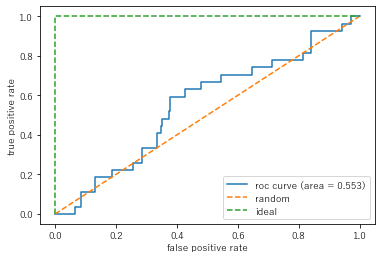

Lasso回帰
auc_テストデータ:0.613


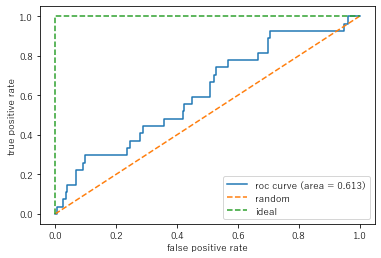

Lasso alpha=1.0
Cross-Validation scores: [0.84848485 0.86363636 0.82575758 0.86363636 0.83333333]
Average score: 0.847
使用された特徴量の数: 140

Lasso回帰
auc_検証用:0.476


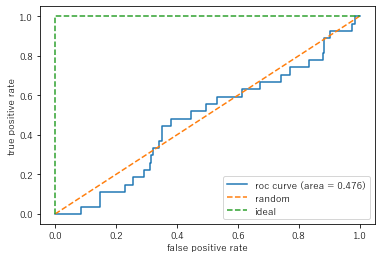

Lasso回帰
auc_テストデータ:0.604


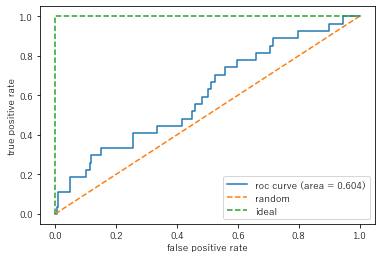

Lasso alpha=10.0
Cross-Validation scores: [0.82575758 0.85606061 0.84848485 0.86363636 0.82575758]
Average score: 0.844
使用された特徴量の数: 175

Lasso回帰
auc_検証用:0.471


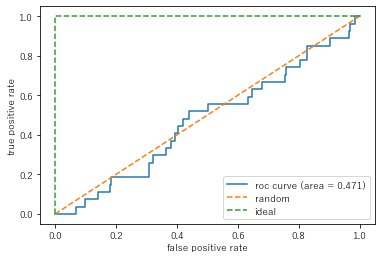

Lasso回帰
auc_テストデータ:0.589


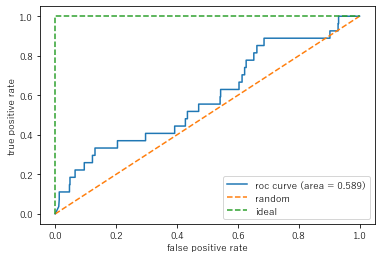

Lasso alpha=100.0
Cross-Validation scores: [0.82575758 0.78030303 0.83333333 0.83333333 0.81060606]
Average score: 0.817
使用された特徴量の数: 237

Lasso回帰
auc_検証用:0.469


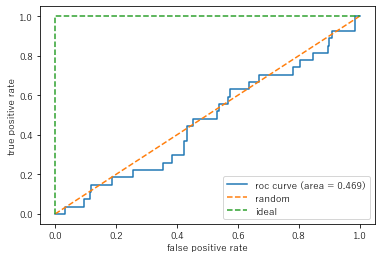

Lasso回帰
auc_テストデータ:0.660


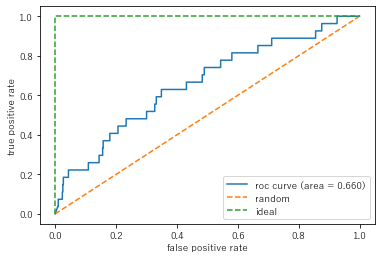

In [10]:
#交差検証とハイパーパラメータのチューニング
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_val,y_train_val)
    predict_lasso = clf_lasso.predict(x_test_val)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_val)

    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_val, y_train_val,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')

    Y_score = clf_lasso.predict_proba(x_test_val)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test_val, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc_検証用:{roc_auc_score(y_true=y_test_val, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

AUCは、ROC (Receiver Operating Characteristic)曲線の下側の面積で、この値が大きいほど分類性能がよいことを示す指標です（最大値は1）。ROC曲線とは、横軸に偽陽性率（FPR: False Positive Rate）を、縦軸に真陽性率（TPR: True Positive Rate）をとった、モデルの分類性能を示した曲線です。クラス分類では、各データがクラス1に属する確率（スコア）を算出し、スコアが閾値を上回っていればデータをクラス1に分類します。したがって、その閾値を変化させると、偽陽性率（実際はクラス0だが誤ってクラス1に分類されるデータの割合）と真陽性率（実際にクラス1で正しくクラス1に分類される確率）が変化します。閾値が極端に大きい場合はどのデータもクラス1に分類されないのでROC曲線は点(0, 0)を通り、閾値が極端に小さい場合はすべてのデータがクラス1に分類されるのでROC曲線は点(1, 1)を通ります。閾値を大きい値から小さい値に変化させていくと、スコアが大きいデータから順にクラス1に分類されるようになります。実際にクラス1のデータのスコアが大きい傾向があれば、真陽性率が偽陽性率よりも早く大きくなり、ROC曲線は点(0, 0)から図の左上を通って点(1, 1)まで描かれます。その結果、ROC曲線の下側の面積であるAUCの値が大きくなります。したがって、AUCは、実際にクラス1のデータに対するスコアが大きめに予測され、実際にクラス0のデータに対するスコアは低めに予測されているかを評価する指標といえます。

lasso回帰で使用された特徴量の数: 123
Lasso回帰
auc:0.612


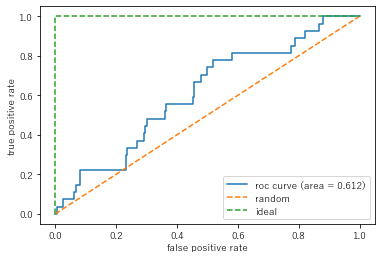

In [13]:
#上記の図からalphaのbestparamaetaを決定
best_param=0.1
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train,y_train)
predict_lasso = clf_lasso.predict(x_test)
predict_lasso_prob = clf_lasso.predict_proba(x_test)

# print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

Y_score = clf_lasso.predict_proba(x_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
print(f'auc_テストデータ:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [14]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'Pass/Fail':y_test,'Pass/Fail_pred':predict_lasso})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'Pass/Fail':y_test, 'Pass/Fail 0 _prob':predict_lasso_prob [:,0], 'Pass/Fail 1 _prob':predict_lasso_prob [:,1]})
display(df_pred_prob)

,Pass/Fail,Pass/Fail_pred
944,0,0
945,1,0
946,0,0
947,0,0
948,0,0
...,...,...
1562,0,0
1563,0,0
1564,0,0
1565,0,0


,Pass/Fail,Pass/Fail 0 _prob,Pass/Fail 1 _prob
944,0,0.992602,7.398300e-03
945,1,0.970271,2.972914e-02
946,0,0.670438,3.295619e-01
947,0,0.957824,4.217616e-02
948,0,0.992507,7.493056e-03
...,...,...,...
1562,0,1.000000,4.295746e-10
1563,0,1.000000,1.302141e-13
1564,0,0.931579,6.842092e-02
1565,0,0.967004,3.299567e-02


In [15]:
#lasso回帰によって絞り込まれた特徴量を抽出
lasso_feature_importance = pd.DataFrame(clf_lasso.coef_).T
lasso_feature_importance['columns'] = pd.DataFrame(x_train.columns)
lasso_feature_importance = lasso_feature_importance.rename(columns={0: 'coef'})
lasso_feature_importance_column = lasso_feature_importance.query('coef != 0')['columns']

In [16]:
#trainとtestに格納
x_train = x_train.loc[:,lasso_feature_importance_column]
x_test = x_test.loc[:,lasso_feature_importance_column]

## 多重共線性の確認
一番効果的なのはVIF(Variance Inflation Factor, 分散拡大要因)』だとされている。<br/>
https://betashort-lab.com/%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%82%B9/%E7%B5%B1%E8%A8%88%E5%AD%A6/vif/
VIFは**“1つの説明変数と他全ての説明変数との関係性を表す指標”** のことで、相関係数に比べて効率良く多重共線性を評価することができる。<br/>
https://www.ushisky.com/datascience/python-multico-vif/

In [17]:
vif_for_confirmation = x_train.loc[:,x_train.columns]

      VIF_Factor features
0    2080.970933        0
1    1005.801920        1
2    9255.682745        2
3     116.048511        3
4      15.238556       14
..           ...      ...
118   541.839154      572
119    91.313916      574
120   455.360526      576
121    12.299008      577
122     2.637851      589

[123 rows x 2 columns]


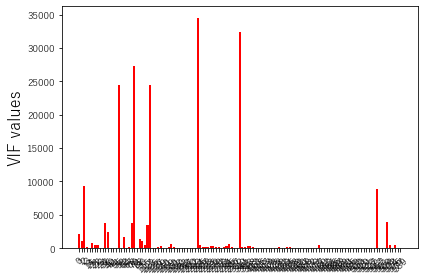

In [18]:
#statsmodelsのvifをインポート
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**一般的にVIF値が10以上の説明変数があると“多重共線性あり”と判断されます。**

In [19]:
vif.query('VIF_Factor >= 10')

,VIF_Factor,features
0,2080.970933,0
1,1005.801920,1
2,9255.682745,2
3,116.048511,3
4,15.238556,14
...,...,...
117,3957.766720,570
118,541.839154,572
119,91.313916,574
120,455.360526,576


**91個の説明変数において多重共線性が確認される**<br/>
どの変数を削除すれば良いのか？<br/>→本来であれば残しておきたい方を考えるのだが、**カラム名の属性情報が分からないため機械的に試していくしかない。**<br/>しかし91!回分プログラムを動かすのは至難なので、今回は<span style="color: red; ">目的変数に与える重要度から説明変数を削除</span>していこうと考える。

In [20]:
x_train_corr_confirm = pd.concat([x_train,y_train],axis=1)

In [21]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

In [22]:
#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

除外する変数: 41


In [23]:
#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

# 再度多重共線性の確認

     VIF_Factor features
0    938.541730        1
1    268.286788       21
2      9.997775       23
3      1.271061       24
4   3565.128549       32
..          ...      ...
77    15.721605      541
78     1.696904      557
79     3.828049      561
80     7.191248      569
81     2.508684      589

[82 rows x 2 columns]


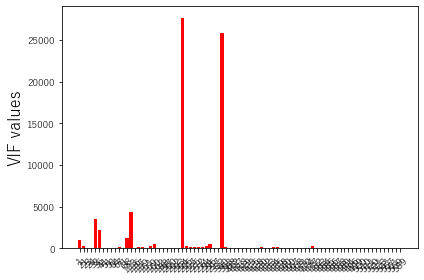

In [24]:
# VIFの算出

vif_for_confirmation = x_train.loc[:,x_train.columns]

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**これを繰り返して多重共線性がなくなるまで行う**

In [25]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

除外する変数: 13


     VIF_Factor features
0    264.624820       21
1      9.869525       23
2      1.245408       24
3   1821.049575       32
4      2.735872       41
..          ...      ...
64     1.590507      523
65     1.677099      557
66     3.775163      561
67     7.065864      569
68     2.416616      589

[69 rows x 2 columns]


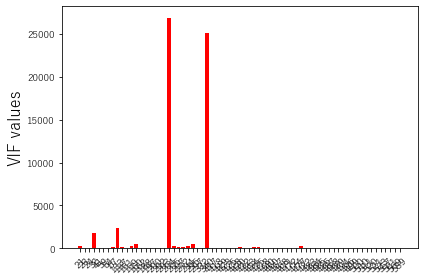

In [26]:
# VIFの算出

vif_for_confirmation = x_train.loc[:,x_train.columns]

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

除外する変数: 4


     VIF_Factor features
0    261.513630       21
1      9.801358       23
2      1.223625       24
3   1798.705346       32
4      2.718028       41
..          ...      ...
60     1.590117      523
61     1.674037      557
62     3.743353      561
63     7.012169      569
64     2.410971      589

[65 rows x 2 columns]


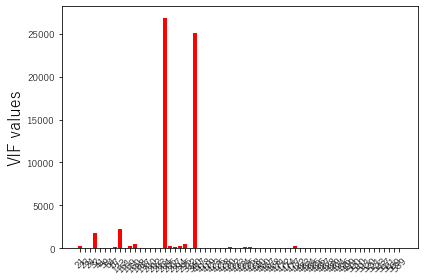

In [29]:
# VIFの算出

vif_for_confirmation = x_train.loc[:,x_train.columns]

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

除外する変数: 1


     VIF_Factor features
0    261.512499       21
1      9.795057       23
2      1.223231       24
3   1797.834141       32
4      2.717013       41
..          ...      ...
59     1.584418      523
60     1.673819      557
61     3.726899      561
62     6.998631      569
63     2.409589      589

[64 rows x 2 columns]


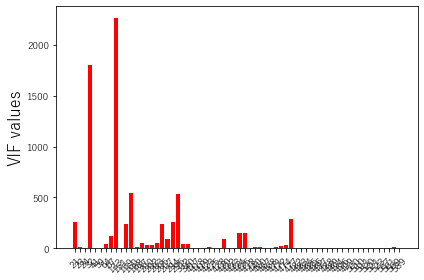

In [31]:
# VIFの算出

vif_for_confirmation = x_train.loc[:,x_train.columns]

# VIFの算出
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(vif_for_confirmation.values, i) for i in range(vif_for_confirmation.shape[1])]
vif["features"] = vif_for_confirmation.columns

# 結果を出力
print(vif)
plt.bar(vif_for_confirmation.columns, vif["VIF_Factor"], color='red')
plt.ylabel('VIF values', fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
#多重共線性のdfと相関のdfを結合
corr = x_train_corr_confirm.corr()
corr = corr['Pass/Fail'].sort_values(ascending=False).to_frame() #相関の高い説明変数の抽出
corr = corr.rename_axis('features').reset_index().iloc[1:,:].rename(columns={'Pass/Fail': 'correlation'}).astype({'features': int}).sort_values('features').reset_index().drop('index',axis=1)
vif = vif.rename(columns={'VIF_Factor': 'VIF','features': 'VIF_features'})
df_vif_compair = pd.concat([vif,corr['correlation']],axis=1)

#相関の中央値より低く、VIFが10以上の変数は除外する
df_corr_median = df_vif_compair['correlation'].median()
exclusion_variable = df_vif_compair[(df_vif_compair['VIF'] >= 10) & (df_vif_compair['correlation'] < df_corr_median)]['VIF_features'].astype(str)
print(f'除外する変数: {len(exclusion_variable)}')

#変数の選定
x_train = x_train.drop(exclusion_variable,axis=1)
x_test = x_test.drop(exclusion_variable,axis=1)
x_train_corr_confirm =  x_train_corr_confirm.drop(exclusion_variable,axis=1)

除外する変数: 0


In [33]:
print(f'多重共線性除外後の特徴量:{len(x_train.columns)}')

多重共線性除外後の特徴量:64


Lasso alpha=0.0001
Cross-Validation scores: [0.92424242 0.92424242 0.92424242 0.92424242 0.92424242]
Average score: 0.924
使用された特徴量の数: 1

Lasso回帰
auc:0.543


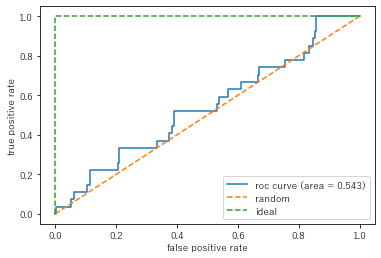

Lasso alpha=0.001
Cross-Validation scores: [0.91666667 0.92424242 0.91666667 0.90909091 0.92424242]
Average score: 0.918
使用された特徴量の数: 15

Lasso回帰
auc:0.559


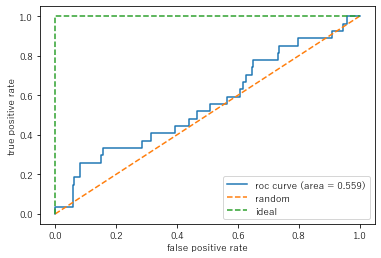

Lasso alpha=0.01
Cross-Validation scores: [0.90909091 0.90909091 0.90909091 0.90151515 0.92424242]
Average score: 0.911
使用された特徴量の数: 35

Lasso回帰
auc:0.593


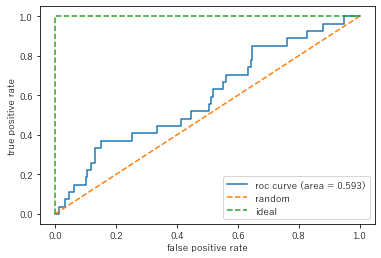

Lasso alpha=0.1
Cross-Validation scores: [0.91666667 0.89393939 0.88636364 0.89393939 0.90151515]
Average score: 0.898
使用された特徴量の数: 55

Lasso回帰
auc:0.636


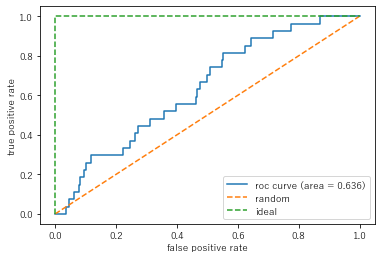

Lasso alpha=1.0
Cross-Validation scores: [0.90909091 0.90151515 0.87878788 0.88636364 0.88636364]
Average score: 0.892
使用された特徴量の数: 62

Lasso回帰
auc:0.649


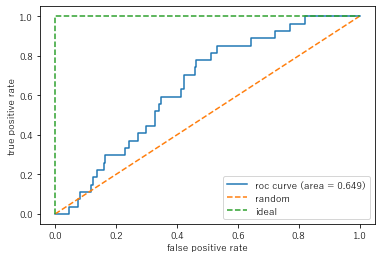

Lasso alpha=10.0
Cross-Validation scores: [0.90909091 0.90151515 0.87121212 0.89393939 0.87878788]
Average score: 0.891
使用された特徴量の数: 64

Lasso回帰
auc:0.631


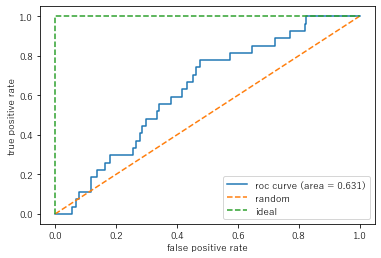

Lasso alpha=100.0
Cross-Validation scores: [0.90151515 0.90151515 0.87121212 0.89393939 0.87878788]
Average score: 0.889
使用された特徴量の数: 64

Lasso回帰
auc:0.630


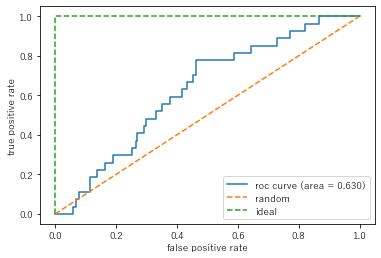

In [34]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_val,y_train_val)
    predict_lasso = clf_lasso.predict(x_test_val)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_val)

    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_val, y_train_val,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')

    Y_score = clf_lasso.predict_proba(x_test_val)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test_val, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test_val, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

**AUCも多少向上している**

lasso回帰で使用された特徴量の数: 64
Lasso回帰
auc_テストデータ:0.657


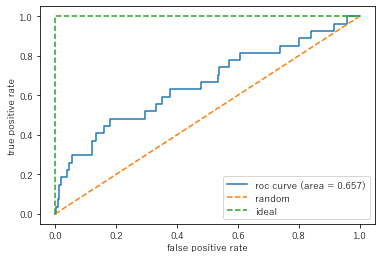

In [36]:
#上記の図からalphaのbestparamaetaを決定
best_param=10.0
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train,y_train)
predict_lasso = clf_lasso.predict(x_test)
predict_lasso_prob = clf_lasso.predict_proba(x_test)

# print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

Y_score = clf_lasso.predict_proba(x_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
print(f'auc_テストデータ:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

反復特徴量選択　→**【実装結果】**説明変数30個まで絞り込んだがAUCを下げた<br/> 
https://qiita.com/rockhopper/items/a68ceb3248f2b3a41c89

まったく特徴量を使わないところから、ある基準が満たされるまで1つずつ重要度が高い特徴量を加えていく、もしくは、すべての特徴量を使う状態から1つずつ特徴量を取り除いていくという操作を繰り返すことで特徴量を選択する。

****

In [37]:
#lasso回帰によって絞り込まれた特徴量を抽出
lasso_feature_importance = pd.DataFrame(clf_lasso.coef_).T
lasso_feature_importance['columns'] = pd.DataFrame(x_train.columns)
lasso_feature_importance = lasso_feature_importance.rename(columns={0: 'coef'})
lasso_feature_importance_column = lasso_feature_importance.query('coef != 0')['columns']

x_train = x_train.loc[:,lasso_feature_importance_column]
x_test = x_test.loc[:,lasso_feature_importance_column]
x_train_corr_confirm = x_train_corr_confirm.loc[:,lasso_feature_importance_column]
x_train_corr_confirm['Pass/Fail'] = y_train

## Group Lassoの実装
https://qiita.com/AnchorBlues/items/4e50d3b98a40c8b3086e

In [ ]:
from grouplasso import GroupLassoRegressor, GroupLassoClassifier

In [ ]:
corr = x_train_corr_confirm.corr()
corr = pd.DataFrame(corr['Pass/Fail'].sort_values(ascending=False)[1:])
corr['abs'] = abs(corr['Pass/Fail'])
corr = corr.sort_values('abs',ascending=False)

In [ ]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',        # 目的 : 2クラス分類  
        'metric': {'binary_error'},   # 評価指標 : 誤り率(= 1-正答率) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# 特徴量重要度の算出 (データフレームで取得)
cols = x_train.columns # 特徴量名のリスト(目的変数と欠損値以外)

f_importance = np.array(model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance.query('importance == 0')) #重要度が低い(ない)変数
display(df_importance.query('importance > 0')) #重要度があるor高い変数

In [ ]:
#group_lasso
gr_ls_corr = pd.DataFrame(x_train.columns,columns={'features'})
gr_ls_corr['id'] = 0
gr_ls_corr = gr_ls_corr.set_index('features')

gr_ls_gbm = pd.DataFrame(x_train.columns,columns={'features'})
gr_ls_gbm['id'] = 0
gr_ls_gbm = gr_ls_gbm.set_index('features')

#相関・lightgbm上位10
corr_gr_ls = corr['abs'].sort_values(ascending=False)[0:10].index
corr_lightgbm_ls = df_importance[0:10].feature

#該当する変数にフラグ付け
gr_ls_corr.loc[corr_gr_ls,'id'] = 1
gr_ls_gbm.loc[corr_lightgbm_ls,'id'] = 1

In [ ]:
corr

In [ ]:
#groupidのためのラベル付け
#143個の説明変数があるため、groupidは12個ずつに分割 → 多く取りすぎて除外できる変数なし
#143個の説明変数があるため、groupidは5個ずつに分割

corr_gr_ls = corr['abs'].sort_values(ascending=False)[0:5].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 1
corr_gr_ls = corr['abs'].sort_values(ascending=False)[5:10].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 2
corr_gr_ls = corr['abs'].sort_values(ascending=False)[10:15].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 3
corr_gr_ls = corr['abs'].sort_values(ascending=False)[15:20].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 4
corr_gr_ls = corr['abs'].sort_values(ascending=False)[20:25].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 5
corr_gr_ls = corr['abs'].sort_values(ascending=False)[25:30].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 6
corr_gr_ls = corr['abs'].sort_values(ascending=False)[30:35].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 7
corr_gr_ls = corr['abs'].sort_values(ascending=False)[35:40].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 8
corr_gr_ls = corr['abs'].sort_values(ascending=False)[40:45].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 9
corr_gr_ls = corr['abs'].sort_values(ascending=False)[45:50].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 10
corr_gr_ls = corr['abs'].sort_values(ascending=False)[50:55].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 11
corr_gr_ls = corr['abs'].sort_values(ascending=False)[55:60].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 12
corr_gr_ls = corr['abs'].sort_values(ascending=False)[60:65].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 13
corr_gr_ls = corr['abs'].sort_values(ascending=False)[65:70].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 14
corr_gr_ls = corr['abs'].sort_values(ascending=False)[70:75].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 15
corr_gr_ls = corr['abs'].sort_values(ascending=False)[75:80].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 16
corr_gr_ls = corr['abs'].sort_values(ascending=False)[80:85].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 17
corr_gr_ls = corr['abs'].sort_values(ascending=False)[85:90].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 18
corr_gr_ls = corr['abs'].sort_values(ascending=False)[90:95].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 19
corr_gr_ls = corr['abs'].sort_values(ascending=False)[95:100].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 20
corr_gr_ls = corr['abs'].sort_values(ascending=False)[100:105].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 21
corr_gr_ls = corr['abs'].sort_values(ascending=False)[105:110].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 22
corr_gr_ls = corr['abs'].sort_values(ascending=False)[110:115].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 23
corr_gr_ls = corr['abs'].sort_values(ascending=False)[115:120].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 24
corr_gr_ls = corr['abs'].sort_values(ascending=False)[120:125].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 25
corr_gr_ls = corr['abs'].sort_values(ascending=False)[125:130].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 26
corr_gr_ls = corr['abs'].sort_values(ascending=False)[130:135].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 27
corr_gr_ls = corr['abs'].sort_values(ascending=False)[135:140].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 28
corr_gr_ls = corr['abs'].sort_values(ascending=False)[140:143].index
gr_ls_corr.loc[corr_gr_ls,'id'] = 29

In [ ]:
#グループ番号の設定
group_ids_corr = np.array(gr_ls_corr['id'])
group_ids_gbm = np.array(gr_ls_gbm['id'])

In [ ]:
group_ids_corr

In [ ]:
group_ids_corr = np.array([22, 26, 15, 20, 29, 25,  8, 23,  1, 26, 15, 25,  5,  5, 20, 22,  9,
       27, 29, 23, 26,  1, 16,  3,  5, 11, 21, 23, 10, 15, 10,  1,  6, 20,
        4, 19, 14, 21, 19,  4,  3, 15, 17,  3, 18, 27, 12,  6,  7,  6, 10,
        8,  4, 13, 10, 12, 13, 16, 17,  4,  3, 14, 15, 11,  8, 13, 11,  6,
       12, 16, 18, 20, 19, 28,  3,  8, 22, 14, 28, 23, 17, 27,  2,  1, 28,
        6,  2,  2,  2,  4, 10, 27, 19, 25,  7, 24, 14, 17, 14,  9, 11, 11,
       24, 18, 21,  7,  8, 20, 25, 12, 27, 17, 13, 12, 22, 18, 18,  1,  5,
       26,  5, 24, 21, 23, 16,  2, 19,  9, 16, 28, 21, 13, 24,  7, 24, 25,
       22,  7, 28,  9,  9, 29, 26])

In [ ]:
x_train_sca = StandardScaler().fit_transform(x_train)

In [ ]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
coef_list = []
eta = 0.2    # 学習率
for alpha in param_grid:
    gr_ls_model = GroupLassoClassifier(group_ids=group_ids_corr, random_state=42, alpha=alpha, verbose=False, eta=eta)

    # モデルの学習
    gr_ls_model.fit(x_train_sca, y_train)

    # モデルの偏回帰係数を出力
    print(f'alpha={alpha}')
    print(gr_ls_model.coef_)
    coef_list.append(gr_ls_model.coef_)

In [ ]:
alpha_df = pd.DataFrame(coef_list,index={"0.0001", "0.001", "0.01", "0.1", "1.0", "10.0", "100.0"}).T
gr_ls_df = pd.DataFrame(x_train.columns,columns={'features'})
gr_ls_df['group_id'] = group_ids_corr
gr_ls_df = pd.concat([gr_ls_df,alpha_df],axis=1)
gr_ls_df = gr_ls_df.set_index('features')

In [ ]:
pd.DataFrame(x_train.columns)

In [ ]:
for i in range(len(dict.fromkeys(group_ids_corr))):
    display(gr_ls_df[gr_ls_df['group_id'] == i+1])

#### 「5」と「42」と「585」の説明変数は除外する

In [ ]:
x_train_gr_lasso = x_train.copy()
x_test_gr_lasso = x_test.copy()

#変数の選定
x_train_gr_lasso = x_train_gr_lasso.drop(['5','42','585'],axis=1)
x_test_gr_lasso = x_test_gr_lasso.drop(['5', '42','585'],axis=1)

In [ ]:
corr

### 相関・変動係数・LightGBMでの特徴量の重要度の確認

In [38]:
corr = x_train_corr_confirm.corr()
corr = pd.DataFrame(corr['Pass/Fail'].sort_values(ascending=False)[1:])
corr['abs'] = abs(corr['Pass/Fail'])
corr = corr.sort_values('abs',ascending=False)

In [39]:
corr[0:10]

,Pass/Fail,abs
21,0.145753,0.145753
59,0.132822,0.132822
510,0.110899,0.110899
434,0.107696,0.107696
430,0.106678,0.106678
435,0.105650,0.105650
64,0.101151,0.101151
295,0.093727,0.093727
160,0.087929,0.087929
471,0.085079,0.085079


In [40]:
#Lassoの係数×標準偏差
cv = clf_lasso.coef_ * np.array(x_train.describe().iloc[2,:])
cv = pd.DataFrame(cv).T
cv['feature'] = x_train.columns
cv = cv.rename(columns={0: 'lasso_cv'})
cv['cv_abs'] = abs(cv['lasso_cv'])
cv = cv.sort_values('cv_abs', ascending=False)
cv.drop('lasso_cv',axis=1)[0:10]

,feature,cv_abs
42,477,6.938689
17,205,4.865210
33,435,4.791506
32,434,2.839966
29,430,2.171210
21,332,1.945110
9,151,1.944200
15,202,1.751144
7,67,1.543180
41,474,1.465000


In [41]:
#変動係数
cv= x_train.describe().iloc[2,:] / x_train.describe().iloc[1,:] #標準偏差/平均値
cv= pd.DataFrame(cv,columns={'cv'})
cv['cv_abs'] = abs(cv)
cv = cv.sort_values('cv_abs', ascending=False)
cv.drop('cv',axis=1)[0:10]

,cv_abs
24,34.293895
340,15.298994
67,15.136070
523,9.457244
521,9.184558
494,6.662168
425,3.867964
435,3.631500
332,2.624667
428,2.477191


説明変数21の散布図


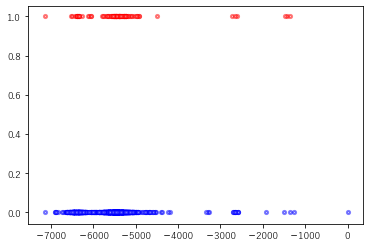

説明変数23の散布図


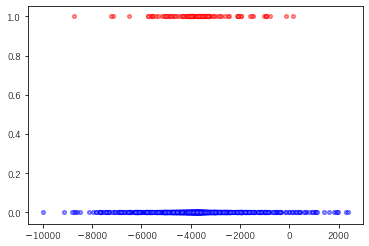

説明変数24の散布図


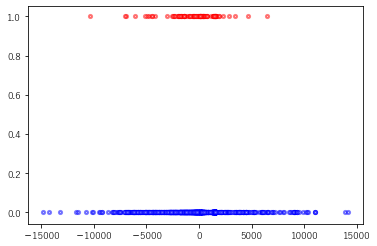

説明変数32の散布図


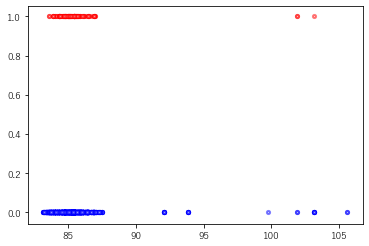

説明変数41の散布図


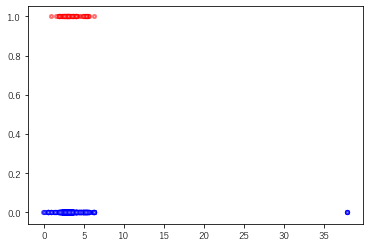

説明変数59の散布図


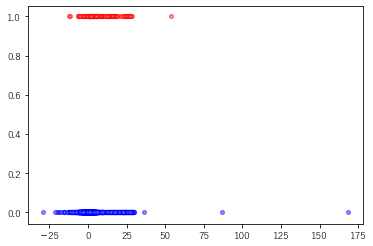

説明変数64の散布図


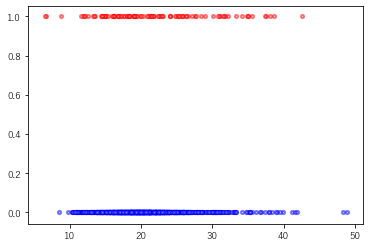

説明変数67の散布図


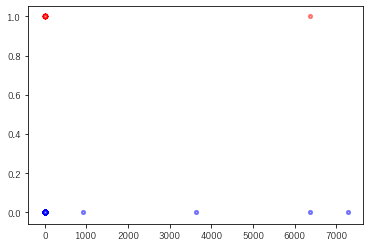

説明変数133の散布図


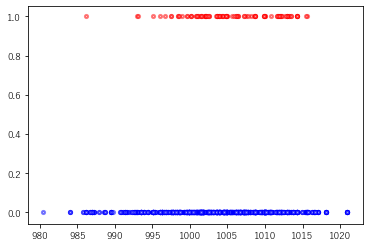

説明変数151の散布図


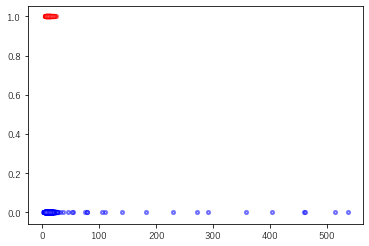

説明変数159の散布図


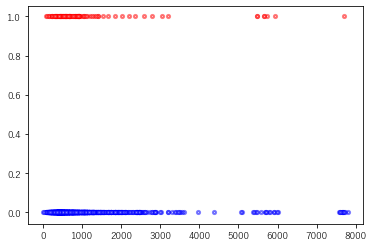

説明変数160の散布図


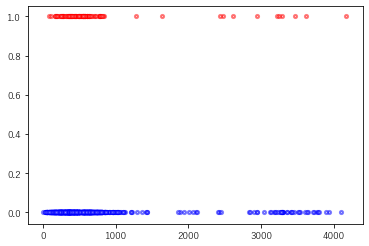

説明変数188の散布図


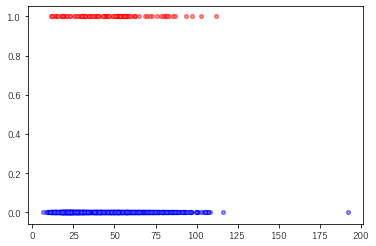

説明変数197の散布図


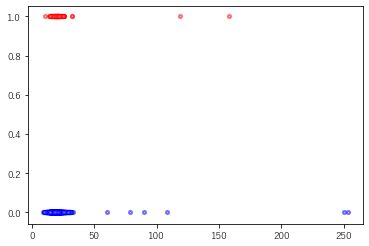

説明変数200の散布図


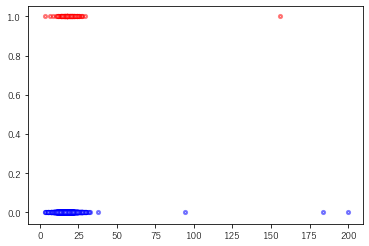

説明変数202の散布図


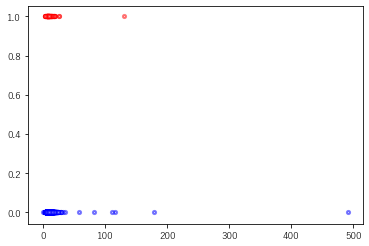

説明変数203の散布図


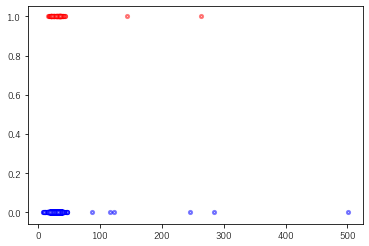

説明変数205の散布図


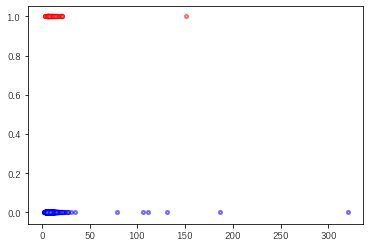

説明変数207の散布図


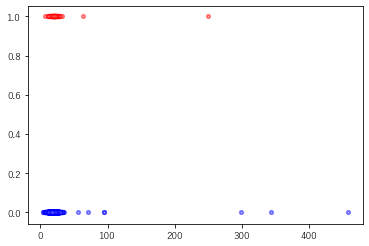

説明変数294の散布図


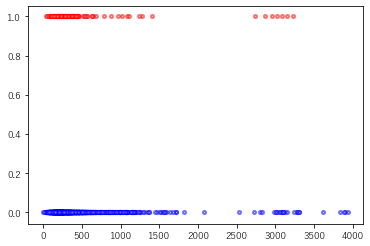

説明変数295の散布図


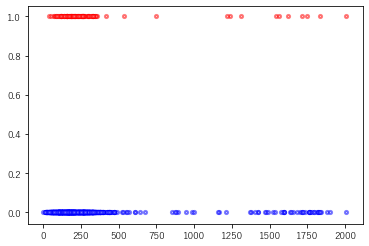

説明変数332の散布図


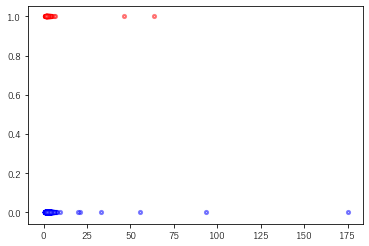

説明変数340の散布図


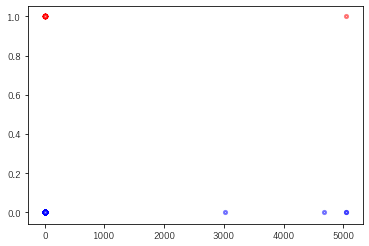

説明変数417の散布図


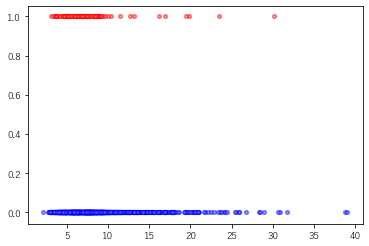

説明変数418の散布図


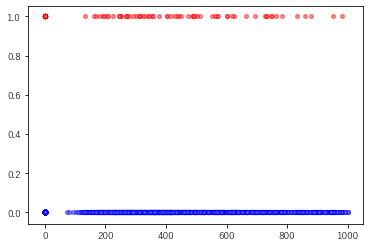

説明変数419の散布図


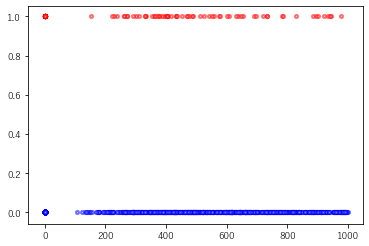

説明変数423の散布図


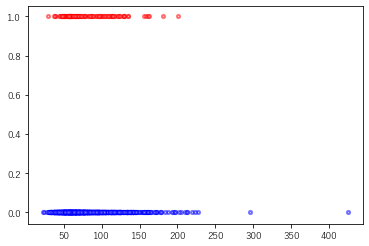

説明変数425の散布図


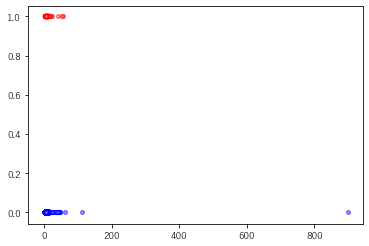

説明変数428の散布図


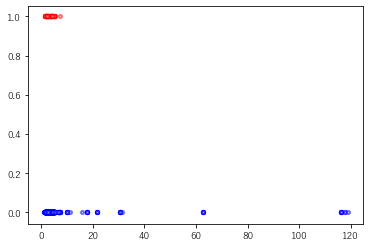

説明変数430の散布図


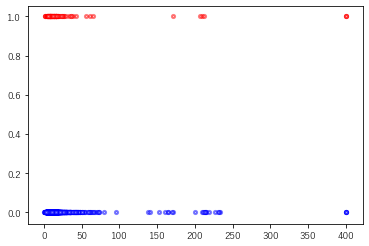

説明変数432の散布図


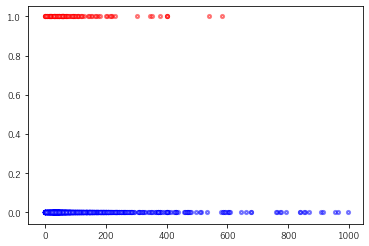

説明変数433の散布図


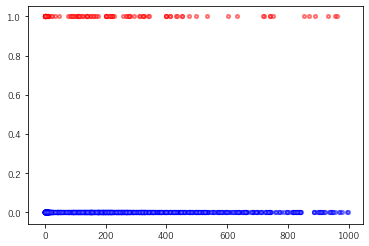

説明変数434の散布図


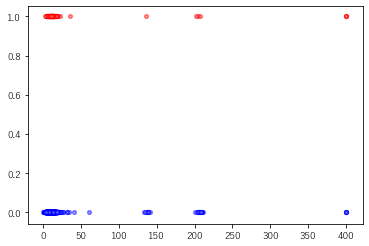

説明変数435の散布図


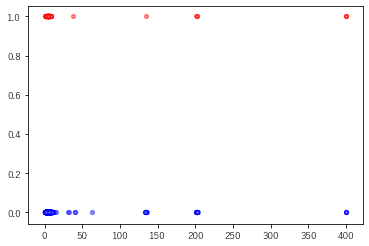

説明変数438の散布図


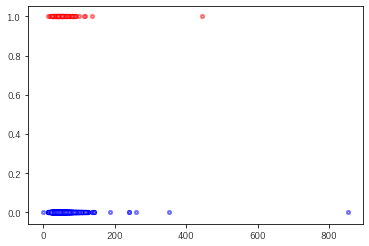

説明変数440の散布図


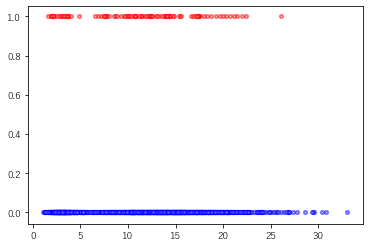

説明変数460の散布図


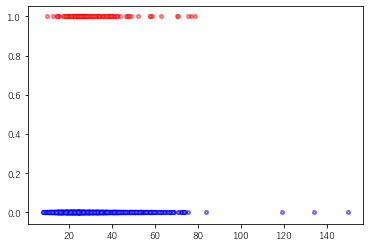

説明変数467の散布図


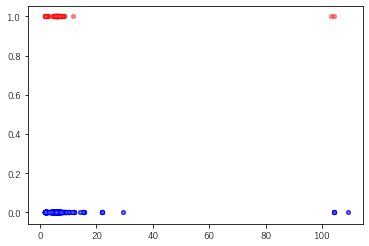

説明変数468の散布図


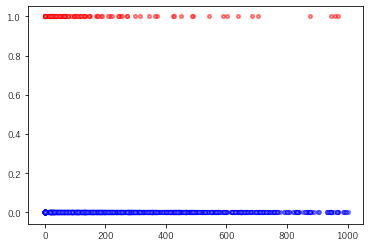

説明変数471の散布図


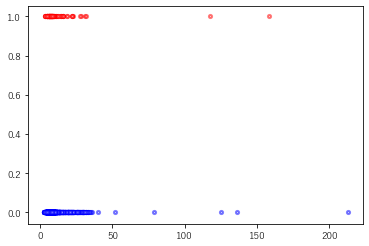

説明変数472の散布図


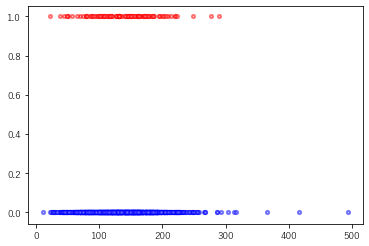

説明変数474の散布図


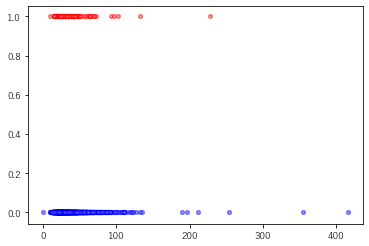

説明変数477の散布図


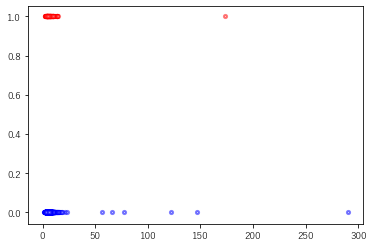

説明変数482の散布図


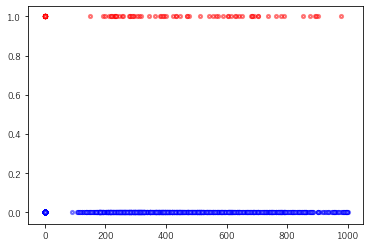

説明変数483の散布図


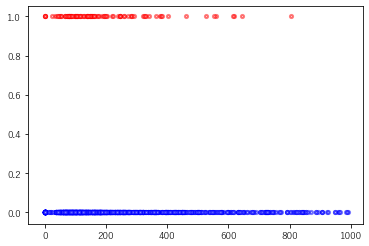

説明変数484の散布図


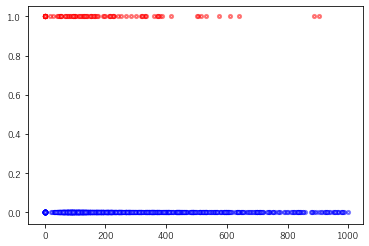

説明変数485の散布図


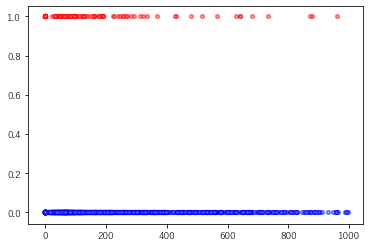

説明変数486の散布図


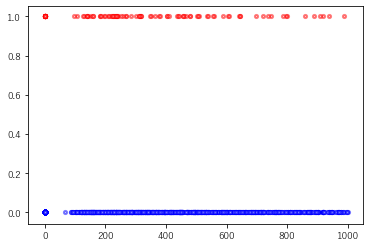

説明変数487の散布図


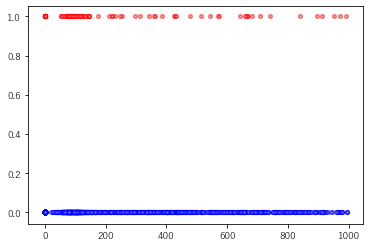

説明変数488の散布図


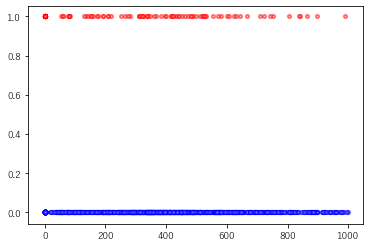

説明変数489の散布図


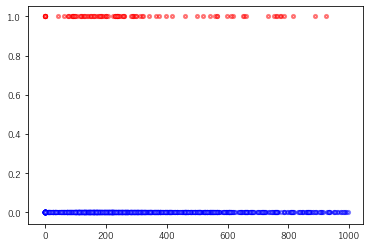

説明変数494の散布図


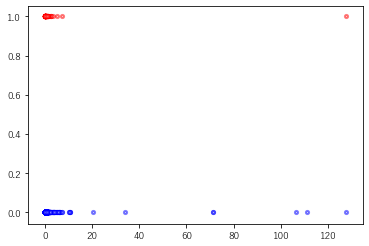

説明変数496の散布図


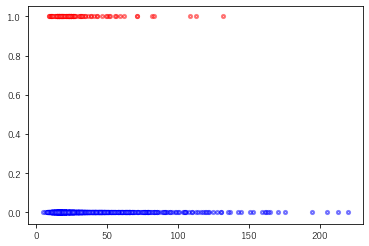

説明変数499の散布図


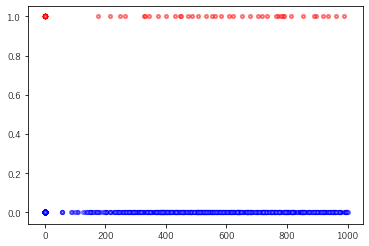

説明変数500の散布図


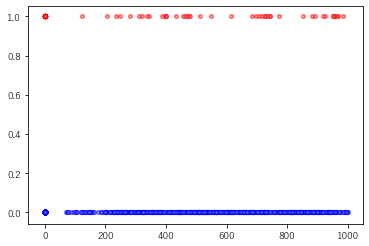

説明変数510の散布図


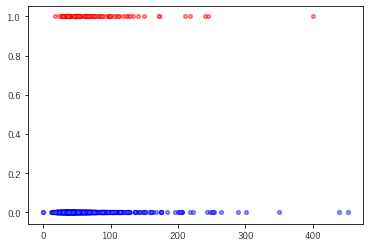

説明変数511の散布図


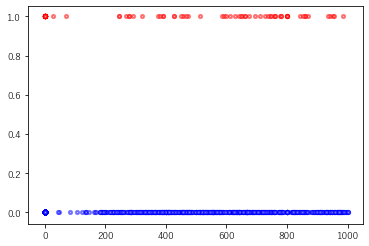

説明変数520の散布図


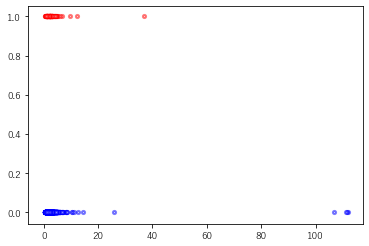

説明変数521の散布図


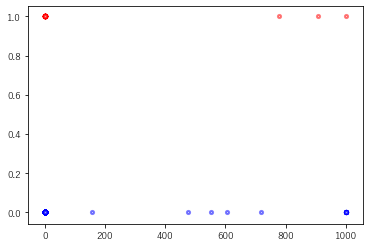

説明変数523の散布図


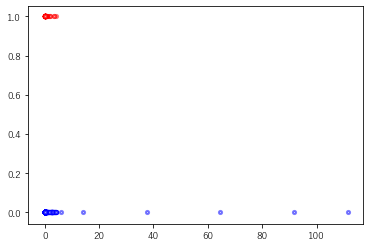

説明変数557の散布図


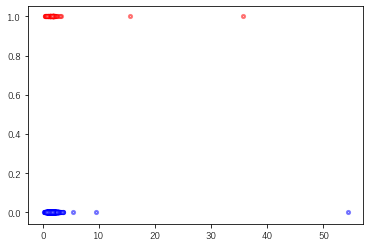

説明変数561の散布図


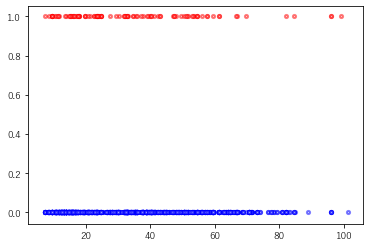

説明変数569の散布図


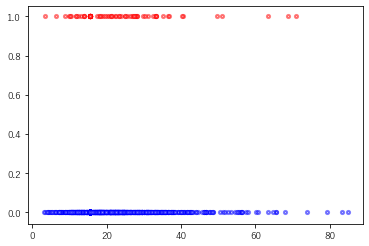

説明変数589の散布図


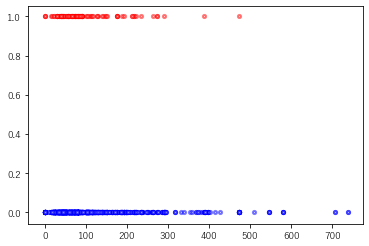

In [42]:
for i in x_train.columns:
    print(f'説明変数{i}の散布図')
    x1 = df[df['Pass/Fail'] == 0][i]
    y1 = df[df['Pass/Fail'] == 0]['Pass/Fail']
    x2 = df[df['Pass/Fail'] == 1][i]
    y2 = df[df['Pass/Fail'] == 1]['Pass/Fail']
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # x1, y1を青色でプロット
    ax.scatter(x1, y1, s=10, alpha=0.5, linewidths=2, c='#aaaaFF', edgecolors='b')
    # x2, y2を赤色でプロット
    ax.scatter(x2, y2, s=10, alpha=0.5, linewidths=2, c='#FFaaaa', edgecolors='r')
    plt.show()

# lightGBMを使用した特徴量の重要度を算出
https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/

In [43]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',        # 目的 : 2クラス分類  
        'metric': {'binary_error'},   # 評価指標 : 誤り率(= 1-正答率) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# 特徴量重要度の算出 (データフレームで取得)
cols = x_train.columns # 特徴量名のリスト(目的変数と欠損値以外)

f_importance = np.array(model.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance.query('importance == 0')) #重要度が低い(ない)変数
display(df_importance.query('importance > 0')) #重要度があるor高い変数

[LightGBM] [Info] Number of positive: 77, number of negative: 867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15154
[LightGBM] [Info] Number of data points in the train set: 944, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081568 -> initscore=-2.421234
[LightGBM] [Info] Start training from score -2.421234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.0433387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.0433387
[3]	valid_0's binary_error: 0.0433387
[4]	valid_0's binary_error: 0.0433387
[5]	valid_0's binary_error: 0.0433387
[6]	valid_0's binary_error: 0.0433387
[7]	valid_0's binary_error: 0.0433387
[8]	valid_0's binary_error: 0.0433387
[9]	valid_0's binary_error: 0.0433387
[10]	valid_0's bi

,feature,importance
58,521,0.0


,feature,importance
5,59,0.065305
0,21,0.047220
6,64,0.035499
8,133,0.032820
57,520,0.023778
...,...,...
29,430,0.007033
24,418,0.007033
41,474,0.006698
53,499,0.005693


In [44]:
df_importance[0:10]

,feature,importance
5,59,0.065305
0,21,0.047220
6,64,0.035499
8,133,0.032820
57,520,0.023778
16,203,0.023778
49,488,0.023443
40,472,0.022103
33,435,0.021433
14,200,0.021098


### lightGBMと相関の共通項「21」「59」「117」の特徴を確認する

In [ ]:
pd.DataFrame(x_train.columns).to_csv('特徴量140個.csv',header=False, index=False)

In [ ]:
def targethist(df, target, save=False, kind='hist', **kwards):
     
    columns = df.columns[df.columns != target]
    pdf = df.pivot_table(index=df.index, columns=target)
     
    for column in columns:
         
        ax = pdf.loc[:, column].plot(kind=kind, title=column, **kwards)
         
        if save==True:
            ax.get_figure().savefig(column+".png") 

In [ ]:
df_importance_features = df[['21','59','117','Pass/Fail']]
targethist(df_importance_features, target="Pass/Fail")

In [ ]:
#21の箱ひげ図

# 合格
Pass = df_median[df_median['Pass/Fail'] == 0]['21']
# 不合格
Fail = df_median[df_median['Pass/Fail'] == 1]['21']
# 点数のタプル
points = (Pass, Fail)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Pass', 'Fail'])

# plt.title('Box plot')
plt.xlabel('result')
plt.ylabel('point')
# Y軸のメモリのrange
plt.ylim([0,-7000])
plt.grid()

# 描画
plt.show()

**Student(スチューデント)のt検定**<br/>
https://qiita.com/suaaa7/items/745ac1ca0a8d6753cf60

In [ ]:
#対応しない2郡間の差の検定
A_var = np.var(Pass, ddof=1)  # Aの不偏分散
B_var = np.var(Fail, ddof=1)  # Bの不偏分散
A_df = len(Pass) - 1  # Aの自由度
B_df = len(Fail) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3))

**p < 0.05なので、帰無仮説は棄却され、2群間は等分散でないことが示唆されました。==t検定できない**

In [ ]:
stats.ttest_ind(Pass, Fail)

**p > 0.05なので、帰無仮説は棄却されず、2群間に差はないということが判断された**

In [ ]:
stats.mannwhitneyu(Pass, Fail, alternative='two-sided')

**p > 0.05なので、帰無仮説は棄却されず、2群の代表値には差があるとはいえない。**

In [ ]:
# #U検定の確認用　外れ値の影響を受けるか否か？
# df_median_59 = df_median.copy()
# df_median_59 = df_median_59.sort_values('59')
# df_median_59 = df_median_59.replace({'59': {168.1455: 10000}})

In [ ]:
#59の箱ひげ図

# 合格
Pass = df_median[df_median['Pass/Fail'] == 0]['59']
# 不合格
Fail = df_median[df_median['Pass/Fail'] == 1]['59']
# 点数のタプル
points = (Pass, Fail)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Pass', 'Fail'])

# plt.title('Box plot')
plt.xlabel('result')
plt.ylabel('point')
# Y軸のメモリのrange
plt.ylim([-50,200])
plt.grid()

# 描画
plt.show()

In [ ]:
#対応しない2郡間の差の検定
A_var = np.var(Pass, ddof=1)  # Aの不偏分散
B_var = np.var(Fail, ddof=1)  # Bの不偏分散
A_df = len(Pass) - 1  # Aの自由度
B_df = len(Fail) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3))

**p < 0.05なので、帰無仮説は棄却され、2群間は等分散でないことが示唆されました。==t検定できない**

In [ ]:
stats.ttest_ind(Pass, Fail)

**p > 0.05なので、帰無仮説は棄却されず、2群間に差はないということが判断された**

In [ ]:
stats.mannwhitneyu(Pass, Fail, alternative='two-sided')

**p < 0.05なので、帰無仮説は棄却され、2群の代表値には差があるといえます。**

In [ ]:
#117の箱ひげ図

# 合格
Pass = df_median[df_median['Pass/Fail'] == 0]['117']
# 不合格
Fail = df_median[df_median['Pass/Fail'] == 1]['117']
# 点数のタプル
points = (Pass, Fail)

# 箱ひげ図
fig, ax = plt.subplots()

bp = ax.boxplot(points)
ax.set_xticklabels(['Pass', 'Fail'])

# plt.title('Box plot')
plt.xlabel('result')
plt.ylabel('point')
# Y軸のメモリのrange
plt.ylim([50,70])
plt.grid()

# 描画
plt.show()

In [ ]:
#対応しない2郡間の差の検定
A_var = np.var(Pass, ddof=1)  # Aの不偏分散
B_var = np.var(Fail, ddof=1)  # Bの不偏分散
A_df = len(Pass) - 1  # Aの自由度
B_df = len(Fail) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3))

**p < 0.05なので、帰無仮説は棄却され、2群間は等分散でないことが示唆されました。==t検定できない**

In [ ]:
stats.ttest_ind(Pass, Fail)

**p > 0.05なので、帰無仮説は棄却されず、2群間に差があるとはいえないということが判断された**

In [ ]:
stats.mannwhitneyu(Pass, Fail, alternative='two-sided')

**p > 0.05なので、帰無仮説は棄却されず、2群の代表値には差があるとはいえない。**

In [ ]:
df_median['59']

### 2変量間の散布図作成

In [ ]:
# 59と21の関係性
x = df_median['59']
y = df_median['21']
 
# 散布図を描画
sns.scatterplot(x,y,hue=df_median['Pass/Fail'])

In [ ]:
# 117と21の関係性
x = df_median['117']
y = df_median['21']
 
# 散布図を描画
sns.scatterplot(x,y,hue=df_median['Pass/Fail'])

In [ ]:
# 50と117の関係性
x = df_median['59']
y = df_median['117']
 
# 散布図を描画
sns.scatterplot(x,y,hue=df_median['Pass/Fail'])

### 「59」「21」「117」の時系列ごとの可視化

In [ ]:
#月のデータ抽出
df_median["Month"] = pd.to_datetime(df_median["Time"]).dt.strftime("%Y-%m")
df_median["Hour"] = pd.to_datetime(df_median["Time"]).dt.strftime("%H")

In [ ]:
list = ['59','21','117']
for i in list:
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,10))
    print(f'{i}の散布図')
    sns.scatterplot(data=df_median , x='Month' ,y=i ,hue=df['Pass/Fail'],ax=ax1)
    sns.scatterplot(data=df_median , x='Hour' ,y=i ,hue=df['Pass/Fail'],ax=ax2)
    plt.xticks(rotation=45)
    plt.show()

### 相関上位10個,特徴量の重要度上位10個の時系列ごとの可視化

In [ ]:
#相関上位10個
for i in corr[0:10].index:
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,10))
    print(f'\n{i}の散布図')
    sns.scatterplot(data=df_median , x='Month' ,y=i ,hue=df['Pass/Fail'],ax=ax1)
    sns.scatterplot(data=df_median , x='Hour' ,y=i ,hue=df['Pass/Fail'],ax=ax2)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
#特徴量の重要度上位10個
for i in df_importance[0:10]['feature']:
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,10))
    print(f'\n{i}の散布図')
    sns.scatterplot(data=df_median , x='Month' ,y=i ,hue=df['Pass/Fail'],ax=ax1)
    sns.scatterplot(data=df_median , x='Hour' ,y=i ,hue=df['Pass/Fail'],ax=ax2)
    plt.xticks(rotation=45)
    plt.show()

### 各変数における時系列の特徴は見受けられない

### 目的変数を予測するために使用される説明変数の傾向を把握するため、散布図で可視化

In [ ]:
# for i in x_train.columns:
#     print(f'説明変数{i}の散布図')
#     x1 = df[df['Pass/Fail'] == 0][i]
#     y1 = df[df['Pass/Fail'] == 0]['Pass/Fail']
#     x2 = df[df['Pass/Fail'] == 1][i]
#     y2 = df[df['Pass/Fail'] == 1]['Pass/Fail']
#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1)

#     # x1, y1を青色でプロット
#     ax.scatter(x1, y1, s=10, alpha=0.5, linewidths=2, c='#aaaaFF', edgecolors='b')
#     # x2, y2を赤色でプロット
#     ax.scatter(x2, y2, s=10, alpha=0.5, linewidths=2, c='#FFaaaa', edgecolors='r')
#     plt.show()

## 重要な変数を抜いた場合のLasso
これで精度が下がれば、重要な変数は最も影響が大きいと判断できる

In [59]:
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

In [60]:
#相関が高かった上位10種類を除いたlasso
x_train_not_feature_importance = x_train_not_feature_importance.drop(corr['abs'][0:10].index,axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(corr['abs'][0:10].index,axis=1)

In [61]:
x_train_not_feature_importance.columns

Index(['23', '24', '32', '41', '67', '133', '151', '159', '188', '197', '200',
       '202', '203', '205', '207', '294', '332', '340', '417', '418', '419',
       '423', '425', '428', '432', '433', '438', '440', '460', '467', '468',
       '472', '474', '477', '482', '483', '484', '485', '486', '487', '488',
       '489', '494', '496', '499', '500', '511', '520', '521', '523', '557',
       '561', '569', '589'],
      dtype='object')

Lasso alpha=0.0001
Cross-Validation scores: [0.92424242 0.92424242 0.90909091 0.91666667 0.92424242]
Average score: 0.920
使用された特徴量の数: 3

Lasso回帰
auc:0.446


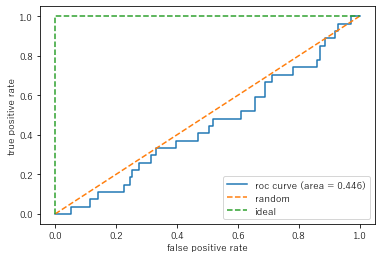

Lasso alpha=0.001
Cross-Validation scores: [0.91666667 0.92424242 0.91666667 0.92424242 0.92424242]
Average score: 0.921
使用された特徴量の数: 15

Lasso回帰
auc:0.544


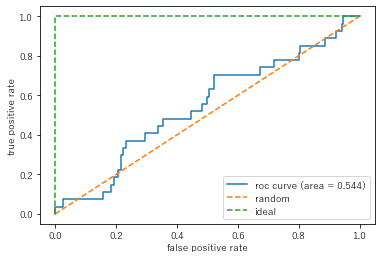

Lasso alpha=0.01
Cross-Validation scores: [0.91666667 0.92424242 0.91666667 0.91666667 0.92424242]
Average score: 0.920
使用された特徴量の数: 32

Lasso回帰
auc:0.550


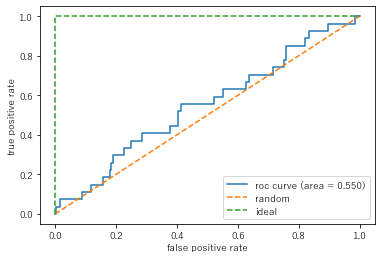

Lasso alpha=0.1
Cross-Validation scores: [0.89393939 0.89393939 0.89393939 0.90909091 0.93181818]
Average score: 0.905
使用された特徴量の数: 47

Lasso回帰
auc:0.519


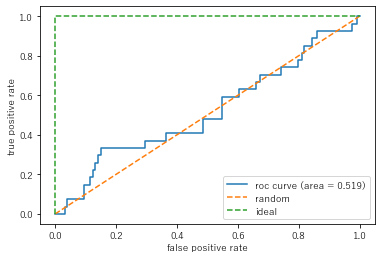

Lasso alpha=1.0
Cross-Validation scores: [0.88636364 0.87878788 0.88636364 0.90909091 0.92424242]
Average score: 0.897
使用された特徴量の数: 51

Lasso回帰
auc:0.520


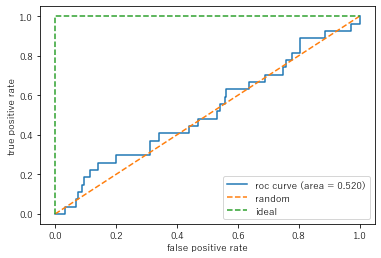

Lasso alpha=10.0
Cross-Validation scores: [0.87878788 0.87121212 0.89393939 0.90909091 0.92424242]
Average score: 0.895
使用された特徴量の数: 54

Lasso回帰
auc:0.520


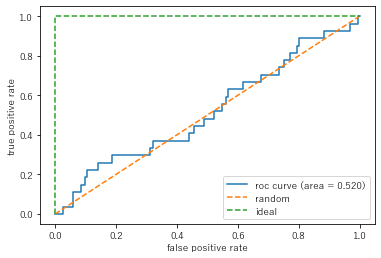

Lasso alpha=100.0
Cross-Validation scores: [0.88636364 0.88636364 0.89393939 0.90909091 0.91666667]
Average score: 0.898
使用された特徴量の数: 54

Lasso回帰
auc:0.529


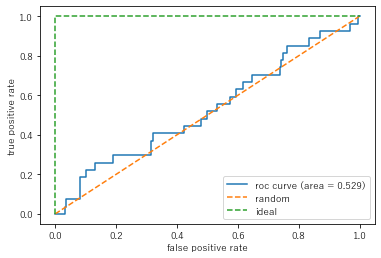

In [62]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x_train_not_feature_importance, y_train, test_size=0.3, random_state=0)

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_val,y_train_val)
    predict_lasso = clf_lasso.predict(x_test_val)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_val)

    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_val, y_train_val,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')

    Y_score = clf_lasso.predict_proba(x_test_val)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test_val, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test_val, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()


lasso回帰で使用された特徴量の数: 33
auc_テストデータ:0.556


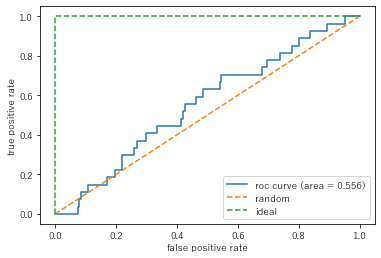

In [64]:
#上記の図からalphaのbestparamaetaを決定
best_param=0.01
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train_not_feature_importance,y_train)
predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)

# print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
print(f'auc_テストデータ:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [69]:
#lightgbmで特徴量の重要度が高かった上位10種類を除いたlasso
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

x_train_not_feature_importance = x_train_not_feature_importance.drop(df_importance[0:10]['feature'],axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(df_importance[0:10]['feature'],axis=1)

In [70]:
x_train_not_feature_importance.columns

Index(['23', '24', '32', '41', '67', '151', '159', '160', '188', '197', '202',
       '205', '207', '294', '295', '332', '340', '417', '418', '419', '423',
       '425', '428', '430', '432', '433', '434', '438', '440', '460', '467',
       '468', '471', '474', '477', '482', '483', '484', '485', '486', '487',
       '489', '494', '496', '499', '500', '510', '511', '521', '523', '557',
       '561', '569', '589'],
      dtype='object')

Lasso alpha=0.0001
Cross-Validation scores: [0.92424242 0.90151515 0.90151515 0.91666667 0.90909091]
Average score: 0.911
使用された特徴量の数: 2

Lasso回帰
auc:0.447


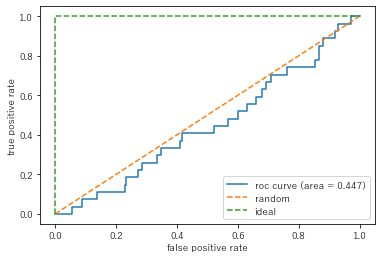

Lasso alpha=0.001
Cross-Validation scores: [0.91666667 0.92424242 0.92424242 0.92424242 0.92424242]
Average score: 0.923
使用された特徴量の数: 20

Lasso回帰
auc:0.556


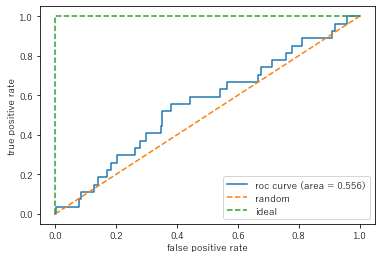

Lasso alpha=0.01
Cross-Validation scores: [0.90909091 0.90151515 0.91666667 0.90909091 0.92424242]
Average score: 0.912
使用された特徴量の数: 32

Lasso回帰
auc:0.553


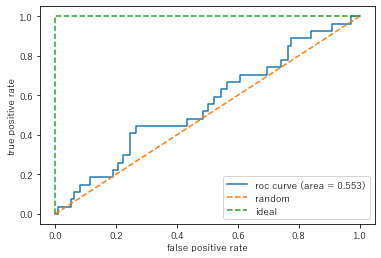

Lasso alpha=0.1
Cross-Validation scores: [0.88636364 0.90151515 0.89393939 0.87878788 0.91666667]
Average score: 0.895
使用された特徴量の数: 50

Lasso回帰
auc:0.523


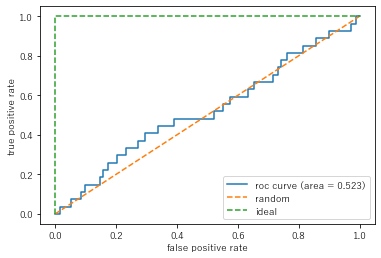

Lasso alpha=1.0
Cross-Validation scores: [0.88636364 0.87878788 0.89393939 0.88636364 0.90909091]
Average score: 0.891
使用された特徴量の数: 54

Lasso回帰
auc:0.528


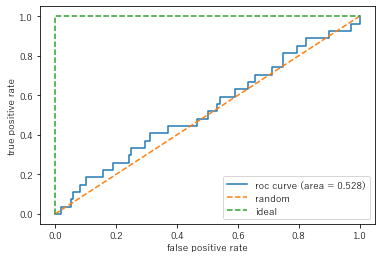

Lasso alpha=10.0
Cross-Validation scores: [0.88636364 0.87878788 0.90909091 0.88636364 0.91666667]
Average score: 0.895
使用された特徴量の数: 53

Lasso回帰
auc:0.530


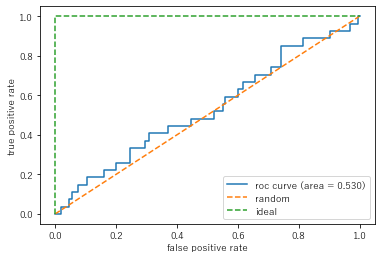

Lasso alpha=100.0
Cross-Validation scores: [0.89393939 0.88636364 0.90909091 0.87878788 0.92424242]
Average score: 0.898
使用された特徴量の数: 54

Lasso回帰
auc:0.535


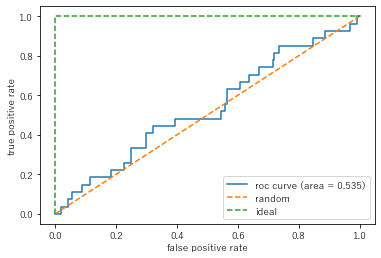

In [71]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x_train_not_feature_importance, y_train, test_size=0.3, random_state=0)

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_val,y_train_val)
    predict_lasso = clf_lasso.predict(x_test_val)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_val)

    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_val, y_train_val,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')

    Y_score = clf_lasso.predict_proba(x_test_val)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test_val, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test_val, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

lasso回帰で使用された特徴量の数: 22
auc_テストデータ:0.528


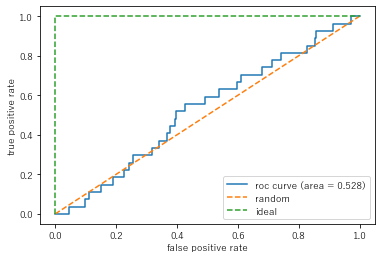

In [72]:
#上記の図からalphaのbestparamaetaを決定
best_param=0.001
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train_not_feature_importance,y_train)
predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)

# print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
print(f'auc_テストデータ:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

### 偶然AUCが落ちたということにならないように、下位10個を除外したパターンも用意

In [73]:
corr['abs'].sort_values()[0:10].index

Index(['432', '425', '489', '41', '589', '23', '520', '487', '561', '523'], dtype='object')

In [74]:
corr['abs'].sort_values()

432    0.001991
425    0.002868
489    0.003317
41     0.003508
589    0.004688
         ...   
430    0.106678
434    0.107696
510    0.110899
59     0.132822
21     0.145753
Name: abs, Length: 64, dtype: float64

In [75]:
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

x_train_not_feature_importance = x_train_not_feature_importance.drop(corr['abs'].sort_values()[0:10].index,axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(corr['abs'].sort_values()[0:10].index,axis=1)

Lasso alpha=0.0001
Cross-Validation scores: [0.92424242 0.92424242 0.92424242 0.92424242 0.92424242]
Average score: 0.924
使用された特徴量の数: 1

Lasso回帰
auc:0.543


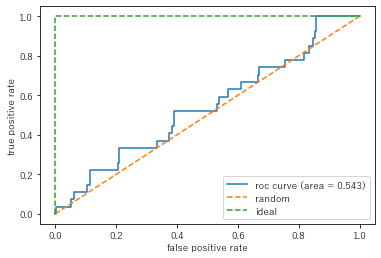

Lasso alpha=0.001
Cross-Validation scores: [0.91666667 0.92424242 0.91666667 0.90151515 0.92424242]
Average score: 0.917
使用された特徴量の数: 13

Lasso回帰
auc:0.570


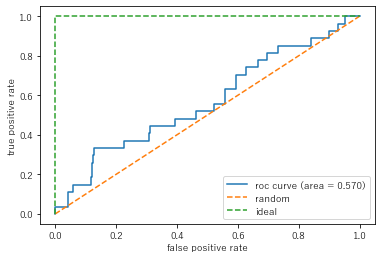

Lasso alpha=0.01
Cross-Validation scores: [0.90909091 0.91666667 0.91666667 0.90151515 0.92424242]
Average score: 0.914
使用された特徴量の数: 31

Lasso回帰
auc:0.607


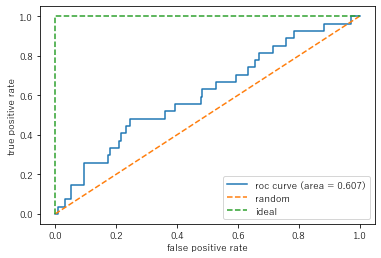

Lasso alpha=0.1
Cross-Validation scores: [0.92424242 0.90909091 0.90151515 0.89393939 0.89393939]
Average score: 0.905
使用された特徴量の数: 46

Lasso回帰
auc:0.660


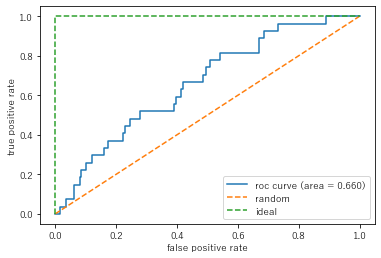

Lasso alpha=1.0
Cross-Validation scores: [0.93181818 0.91666667 0.90909091 0.91666667 0.88636364]
Average score: 0.912
使用された特徴量の数: 51

Lasso回帰
auc:0.686


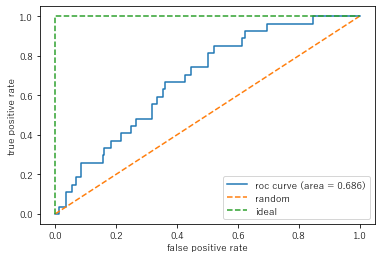

Lasso alpha=10.0
Cross-Validation scores: [0.92424242 0.91666667 0.89393939 0.90909091 0.87878788]
Average score: 0.905
使用された特徴量の数: 53

Lasso回帰
auc:0.688


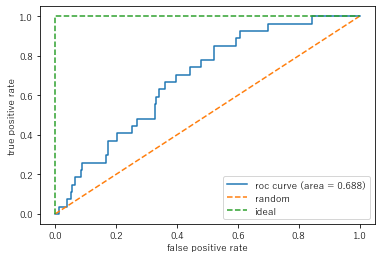

Lasso alpha=100.0
Cross-Validation scores: [0.92424242 0.91666667 0.89393939 0.90909091 0.87878788]
Average score: 0.905
使用された特徴量の数: 54

Lasso回帰
auc:0.688


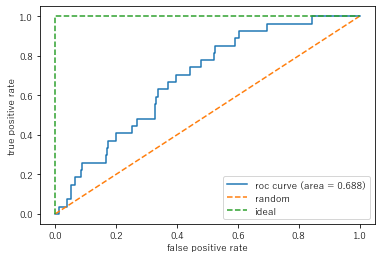

In [76]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x_train_not_feature_importance, y_train, test_size=0.3, random_state=0)

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_val,y_train_val)
    predict_lasso = clf_lasso.predict(x_test_val)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_val)

    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_val, y_train_val,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')

    Y_score = clf_lasso.predict_proba(x_test_val)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test_val, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test_val, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

lasso回帰で使用された特徴量の数: 54
auc_テストデータ:0.641


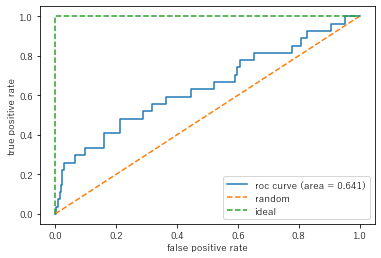

In [77]:
#上記の図からalphaのbestparamaetaを決定
best_param=10.0
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train_not_feature_importance,y_train)
predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)

# print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
print(f'auc_テストデータ:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [78]:
df_importance.sort_values('importance')[0:10]['feature']

58    521
54    500
53    499
41    474
24    418
29    430
20    295
19    294
10    159
42    477
Name: feature, dtype: object

In [79]:
x_train_not_feature_importance = x_train.copy()
x_test_not_feature_importance = x_test.copy()

In [80]:
x_train_not_feature_importance = x_train_not_feature_importance.drop(df_importance.sort_values('importance')[0:10]['feature'],axis=1)
x_test_not_feature_importance = x_test_not_feature_importance.drop(df_importance.sort_values('importance')[0:10]['feature'],axis=1)

Lasso alpha=0.0001
Cross-Validation scores: [0.92424242 0.92424242 0.92424242 0.92424242 0.92424242]
Average score: 0.924
使用された特徴量の数: 1

Lasso回帰
auc:0.543


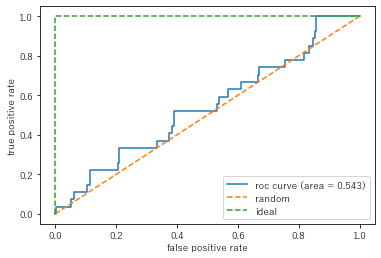

Lasso alpha=0.001
Cross-Validation scores: [0.91666667 0.92424242 0.91666667 0.90909091 0.92424242]
Average score: 0.918
使用された特徴量の数: 13

Lasso回帰
auc:0.567


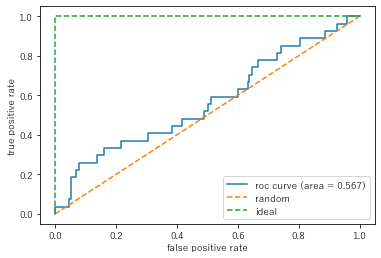

Lasso alpha=0.01
Cross-Validation scores: [0.90909091 0.91666667 0.91666667 0.92424242 0.92424242]
Average score: 0.918
使用された特徴量の数: 31

Lasso回帰
auc:0.601


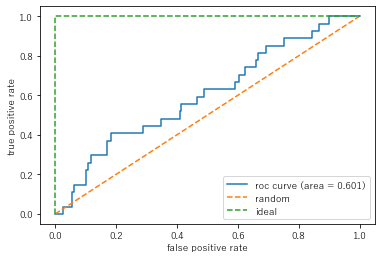

Lasso alpha=0.1
Cross-Validation scores: [0.90151515 0.91666667 0.88636364 0.90909091 0.91666667]
Average score: 0.906
使用された特徴量の数: 45

Lasso回帰
auc:0.616


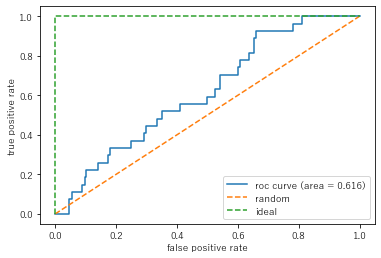

Lasso alpha=1.0
Cross-Validation scores: [0.90909091 0.90151515 0.87121212 0.90909091 0.88636364]
Average score: 0.895
使用された特徴量の数: 52

Lasso回帰
auc:0.599


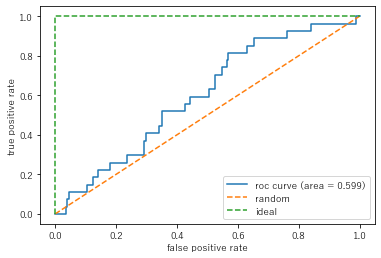

Lasso alpha=10.0
Cross-Validation scores: [0.90909091 0.90151515 0.87121212 0.91666667 0.88636364]
Average score: 0.897
使用された特徴量の数: 54

Lasso回帰
auc:0.596


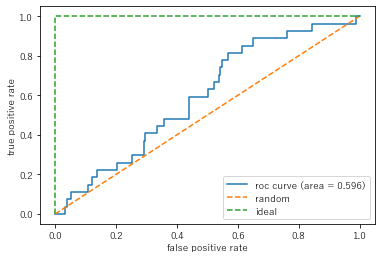

Lasso alpha=100.0
Cross-Validation scores: [0.90909091 0.90151515 0.87121212 0.91666667 0.88636364]
Average score: 0.897
使用された特徴量の数: 54

Lasso回帰
auc:0.596


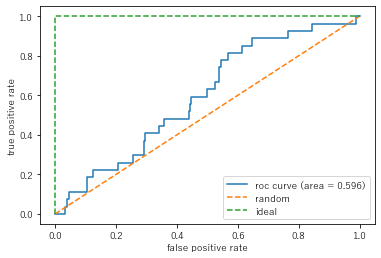

In [81]:
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(x_train_not_feature_importance, y_train, test_size=0.3, random_state=0)

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_val,y_train_val)
    predict_lasso = clf_lasso.predict(x_test_val)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_val)

    print(f'Lasso alpha={alpha}')
    scores = cross_val_score(clf_lasso, x_train_val, y_train_val,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア

    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')

    Y_score = clf_lasso.predict_proba(x_test_val)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test_val, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test_val, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

lasso回帰で使用された特徴量の数: 48
auc_テストデータ:0.635


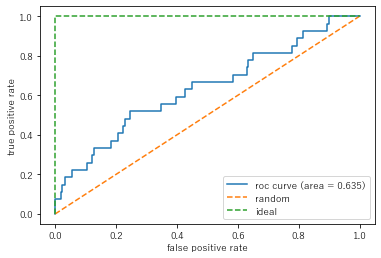

In [83]:
#上記の図からalphaのbestparamaetaを決定
best_param=0.1
clf_lasso = LogisticRegression(C=best_param,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
clf_lasso.fit(x_train_not_feature_importance,y_train)
predict_lasso = clf_lasso.predict(x_test_not_feature_importance)
predict_lasso_prob = clf_lasso.predict_proba(x_test_not_feature_importance)

# print(f'lasso回帰の係数: {clf_lasso.coef_}')
print(f'lasso回帰で使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}')

Y_score = clf_lasso.predict_proba(x_test_not_feature_importance)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
print(f'auc_テストデータ:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

#### 上位の変数を除いた時と比較して、下がり幅が少ない

## **【絞り込み】** t検定による絞り込み

In [ ]:
#現時点での変数
x_train.columns

In [ ]:
features=x_train.columns
depend_feature_t_certificate=[]
depend_feature_u_certificate=[]

for features in features:
    # 合格
    Pass = df_median[df_median['Pass/Fail'] == 0][features]
    # 不合格
    Fail = df_median[df_median['Pass/Fail'] == 1][features]

    #対応しない2郡間の差の検定
    A_var = np.var(Pass, ddof=1)  # Aの不偏分散
    B_var = np.var(Fail, ddof=1)  # Bの不偏分散
    A_df = len(Pass) - 1  # Aの自由度
    B_df = len(Fail) - 1  # Bの自由度
    
    try:
        f = A_var / B_var  # F比の値
        one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
        one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
        two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値

#         print(f'説明変数「{features}」のt検定P値:{stats.ttest_ind(Pass, Fail)[1]}')
#         print(f'説明変数「{features}」のu検定P値:{stats.mannwhitneyu(Pass, Fail, alternative='two-sided')[1]}')
        
        if stats.ttest_ind(Pass, Fail)[1] < 0.05:
            depend_feature_t_certificate.append(features)
        elif stats.mannwhitneyu(Pass, Fail, alternative='two-sided')[1] < 0.05:
            depend_feature_u_certificate.append(features)
        else:
            continue
    except ZeroDivisionError:
        pass

In [ ]:
len(depend_feature_t_certificate)

In [ ]:
x_train_t_certificate = x_train.copy()
x_test_t_certificate = x_test.copy()

x_train_u_certificate = x_train.copy()
x_test_u_certificate = x_test.copy()

#変数の選定
x_train_t_certificate = x_train_t_certificate[depend_feature_t_certificate]
x_test_t_certificate = x_test_t_certificate[depend_feature_t_certificate]

x_train_u_certificate = x_train_u_certificate[depend_feature_u_certificate]
x_test_u_certificate = x_test_u_certificate[depend_feature_u_certificate]

print(x_train_t_certificate.shape,x_test_t_certificate.shape)
print(x_train_u_certificate.shape,x_test_u_certificate.shape)

In [ ]:
#t検定
#交差検証とハイパーパラメータのチューニング
param_grid = [0.0001 , 0.001, 0.01, 0.1, 1.0, 10.0,100.0]

for alpha in param_grid:
    clf_lasso = LogisticRegression(C=alpha,penalty = "l1",solver = "liblinear") #lassoと同じ正則化
    clf_lasso.fit(x_train_t_certificate,y_train)
    predict_lasso = clf_lasso.predict(x_test_t_certificate)
    predict_lasso_prob = clf_lasso.predict_proba(x_test_t_certificate)
    
    print(f'Lasso alpha={alpha}')
#     print(clf_lasso.intercept_)
#     print(clf_lasso.coef_)
    scores = cross_val_score(clf_lasso, x_train_t_certificate, y_train,cv=5)
    print(f'Cross-Validation scores: {scores}') # 各分割におけるスコア
    print(f'Average score: {np.mean(scores):.3f}') #平均スコア
#     print(f'trainning data:に対しての精度: {clf_lasso.score(x_train,y_train):.3f}')
#     print(f'test data:に対しての精度: {clf_lasso.score(x_test,y_test):.3f}')
    print(f'使用された特徴量の数: {np.sum(clf_lasso.coef_ != 0)}\n')
    
    Y_score = clf_lasso.predict_proba(x_test_t_certificate)[:, 1] # 検証データがクラス1に属する確率
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=Y_score)
    print('Lasso回帰')
    print(f'auc:{roc_auc_score(y_true=y_test, y_score=Y_score):.3f}')

    plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], linestyle='--', label='random')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

### t検定で絞り込んだ変数での予測は下がった

### まとめ


- 本データは2008年7月~9月に集中しており、不良品の割合も多いため何らかの背景事情が存在している可能性がある
- Lasso回帰・多重共線性の確認・Group lasso回帰を行った結果有用な説明変数は140個存在する
- 単変量の観点から相関上位10個・特徴量の重要度上位10個の変数が目的変数に影響を及ぼしている推察される。特に「59」「21」「117」の説明変数が工程プロセスに大きな影響を与えていると推察される
- 「uci_analysis_Decision_tree.ipynb」のRulefitより、多変量の観点から「65」と「224」 ,「341」と「59」 ,「40」と「426」の組み合わせが不良品に分類する際の要因となり得る